In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [7]:
file_path = "https://raw.githubusercontent.com/dths8/DSA4263_Vehicle-Insurance-Fraud-Detection/refs/heads/main/data/"
df_original = pd.read_csv(file_path + "original_cleaned_dataset.csv")
df_smote = pd.read_csv(file_path + "smote_dataset.csv")
df_weighted = pd.read_csv(file_path + "oversampled_dataset.csv")
df_adasyn = pd.read_csv(file_path + "adasyn_dataset.csv")
df_test = pd.read_csv(file_path + "test_dataset.csv")


In [8]:
# calculcate class weights for the original cleaned dataset
class_weights_original = compute_class_weight('balanced', classes=np.unique(df_original['fraud_reported']), y=df_original['fraud_reported'])
class_weight_dict_original = dict(zip(np.unique(df_original['fraud_reported']), class_weights_original))
df_original_with_weight = df_original.copy()

# calculate class weights for the oversampled dataset
class_weights_oversampled = compute_class_weight('balanced', classes=np.unique(df_weighted['fraud_reported']), y=df_weighted['fraud_reported'])
class_weight_dict_oversampled = dict(zip(np.unique(df_weighted['fraud_reported']), class_weights_oversampled))

In [ ]:
# create a random forest model and train on the 5 dataset to determine fraud cases
datasets = [df_original, df_original_with_weight, df_smote, df_adasyn, df_weighted]
x_test = df_test.drop('fraud_reported', axis=1)
y_test = df_test['fraud_reported']
rf_models = []
for i in range(len(datasets)):
  if datasets[i] is df_original_with_weight:
    model = RandomForestClassifier(random_state=4263, class_weight=class_weight_dict_original)
  elif datasets[i] is df_weighted:
    model = RandomForestClassifier(random_state=4263, class_weight=class_weight_dict_oversampled)
  else:
    model = RandomForestClassifier(random_state=4263)

  model.fit(datasets[i].drop('fraud_reported', axis=1), datasets[i]['fraud_reported'])

  rf_models.append(model)


In [ ]:
# create a logistic regression model and train on the 5 dataset to determine fraud cases
logit_models = []
for i in range(len(datasets)):
  if datasets[i] is df_original_with_weight:
    model = LogisticRegression(random_state=4263, class_weight=class_weight_dict_original, max_iter = 1000)
  elif datasets[i] is df_weighted:
    model = LogisticRegression(random_state=4263, class_weight=class_weight_dict_oversampled, max_iter = 1000)
  else:
    model = LogisticRegression(random_state=4263, max_iter = 1000)
  model.fit(datasets[i].drop('fraud_reported', axis=1), datasets[i]['fraud_reported'])
  logit_models.append(model)

In [ ]:
# calculate the count of each class in the original dataset
class_counts = df_original['fraud_reported'].value_counts()

negative_count = class_counts[0]
positive_count = class_counts[1]

scale_pos_weight_original = negative_count / positive_count

# calculate the count of each class in the weighted dataset
class_counts_weighted = df_weighted['fraud_reported'].value_counts()

negative_count_weighted = class_counts_weighted[0]
positive_count_weighted = class_counts_weighted[1]

scale_pos_weight_weighted = negative_count_weighted / positive_count_weighted


In [ ]:
# create a xgboost model and train on the 5 dataset to determine fraud cases
xgb_models = []
for i in range(len(datasets)):
  if datasets[i] is df_original_with_weight:
    model = xgb.XGBClassifier(random_state=4263, scale_pos_weight = scale_pos_weight_original)
  elif datasets[i] is df_weighted:
    model = xgb.XGBClassifier(random_state=4263, scale_pos_weight = scale_pos_weight_weighted)
  else:
    model = xgb.XGBClassifier(random_state=4263)
  model.fit(datasets[i].drop('fraud_reported', axis=1), datasets[i]['fraud_reported'])
  xgb_models.append(model)


In [ ]:
# calculate the accuracy, precision, recall, f1 score of the models
dataset_names = ['Original', 'Original with Weight','SMOTE', 'ADASYN', 'Oversampled']

# create empty lists to store the metrics
rf_accuracy = []
rf_precision = []
rf_recall = []
rf_f1 = []

logit_accuracy = []
logit_precision = []
logit_recall = []
logit_f1 = []

xgb_accuracy = []
xgb_precision = []
xgb_recall = []
xgb_f1 = []

for i in range(len(rf_models)):
  y_pred = rf_models[i].predict(x_test)
  rf_accuracy.append(accuracy_score(y_test, y_pred))
  rf_precision.append(precision_score(y_test, y_pred))
  rf_recall.append(recall_score(y_test, y_pred))
  rf_f1.append(f1_score(y_test, y_pred))

  y_pred_logit = logit_models[i].predict(x_test)
  logit_accuracy.append(accuracy_score(y_test, y_pred_logit))
  logit_precision.append(precision_score(y_test, y_pred_logit))
  logit_recall.append(recall_score(y_test, y_pred_logit))
  logit_f1.append(f1_score(y_test, y_pred_logit))

  y_pred_xgb = xgb_models[i].predict(x_test)
  xgb_accuracy.append(accuracy_score(y_test, y_pred_xgb))
  xgb_precision.append(precision_score(y_test, y_pred_xgb))
  xgb_recall.append(recall_score(y_test, y_pred_xgb))
  xgb_f1.append(f1_score(y_test, y_pred_xgb))

# create DataFrames for the metrics
rf_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': rf_accuracy,
    'Precision': rf_precision,
    'Recall': rf_recall,
    'F1 Score': rf_f1
})

logit_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': logit_accuracy,
    'Precision': logit_precision,
    'Recall': logit_recall,
    'F1 Score': logit_f1
})

xgb_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': xgb_accuracy,
    'Precision': xgb_precision,
    'Recall': xgb_recall,
    'F1 Score': xgb_f1
})

print("Random Forest Model Metrics:")
display(rf_metrics_df)

print("\nLogistic Regression Model Metrics:")
display(logit_metrics_df)

print("\nXGBoost Model Metrics:")
display(xgb_metrics_df)

Random Forest Model Metrics:


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.780,0.666667,0.24,0.352941
1,Original with Weight,0.785,0.684211,0.26,0.376812
2,SMOTE,0.800,0.631579,0.48,0.545455
3,ADASYN,0.780,0.593750,0.38,0.463415
4,Oversampled,0.790,0.633333,0.38,0.475000



Logistic Regression Model Metrics:


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.820,0.675000,0.54,0.600000
1,Original with Weight,0.785,0.549296,0.78,0.644628
2,SMOTE,0.815,0.651163,0.56,0.602151
3,ADASYN,0.810,0.642857,0.54,0.586957
4,Oversampled,0.815,0.622642,0.66,0.640777



XGBoost Model Metrics:


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.780,0.578947,0.44,0.500000
1,Original with Weight,0.795,0.609756,0.50,0.549451
2,SMOTE,0.815,0.675676,0.50,0.574713
3,ADASYN,0.805,0.627907,0.54,0.580645
4,Oversampled,0.785,0.594595,0.44,0.505747


In [ ]:
# comparison of the 3 models in one table
models_comparison = pd.DataFrame({
    'Dataset': dataset_names,
    'Random Forest F1': rf_f1,
    'Logistic Regression F1': logit_f1,
    'XGBoost F1': xgb_f1,
})

display(models_comparison)

,Dataset,Random Forest F1,Logistic Regression F1,XGBoost F1
0,Original,0.352941,0.600000,0.500000
1,Original with Weight,0.376812,0.644628,0.549451
2,SMOTE,0.545455,0.602151,0.574713
3,ADASYN,0.463415,0.586957,0.580645
4,Oversampled,0.475000,0.640777,0.505747


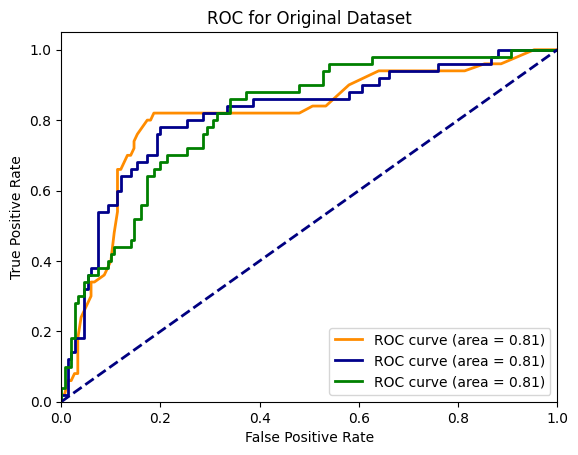

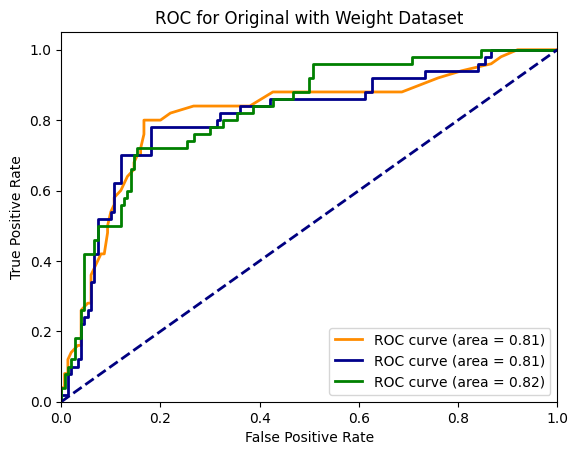

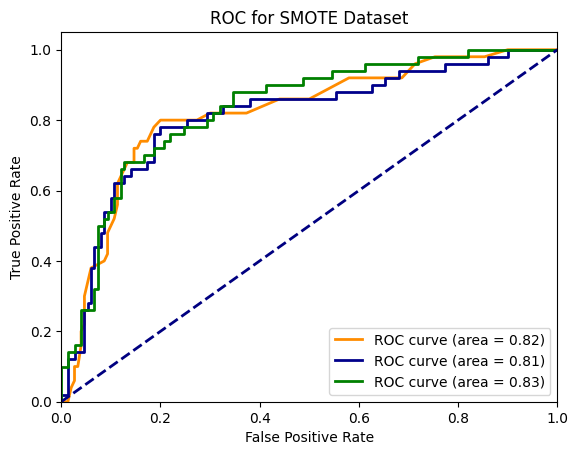

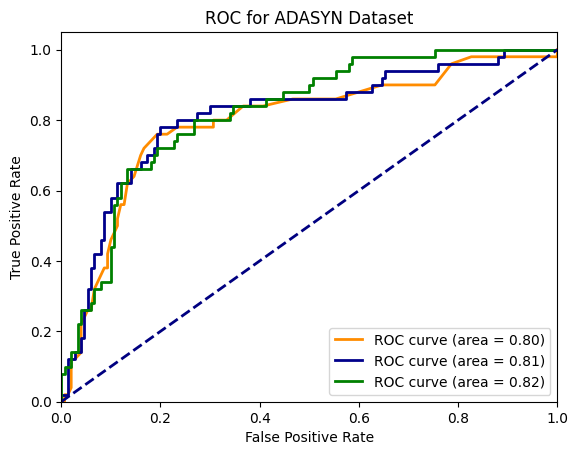

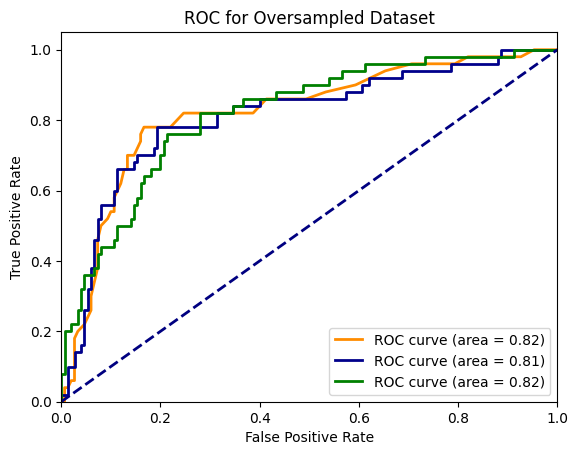

In [ ]:
# plot ROC-AUC curve and compare between RF model, LR model and XGB model for each dataset
for i in range(len(rf_models)):
  y_pred_rf = rf_models[i].predict_proba(x_test)[:, 1]
  fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
  roc_auc_rf = auc(fpr_rf, tpr_rf)
  plt.figure()
  plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)

  y_pred_logit = logit_models[i].predict_proba(x_test)[:, 1]
  fpr_logit, tpr_logit, _ = roc_curve(y_test, y_pred_logit)
  roc_auc_logit = auc(fpr_logit, tpr_logit)
  plt.plot(fpr_logit, tpr_logit, color='darkblue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_logit)
  y_pred_xgb = xgb_models[i].predict_proba(x_test)[:, 1]
  fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
  roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
  plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_xgb)

  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC for {dataset_names[i]} Dataset')
  plt.legend(loc="lower right")
  plt.show()


## Hyperparameter tuning



In [ ]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

param_grid_logit = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

best_rf_models = []
best_logit_models = []
best_xgb_models = []

# Perform GridSearchCV for each model and dataset
for i in range(len(datasets)):
    X_train = datasets[i].drop('fraud_reported', axis=1)
    y_train = datasets[i]['fraud_reported']

    # rf
    print(f"Tuning Random Forest on {dataset_names[i]} dataset...")
    if datasets[i] is df_original_with_weight:
        rf_model = RandomForestClassifier(random_state=4263, class_weight=class_weight_dict_original)
    elif datasets[i] is df_weighted:
        rf_model = RandomForestClassifier(random_state=4263, class_weight=class_weight_dict_oversampled)
    else:
        rf_model = RandomForestClassifier(random_state=4263)

    grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, scoring='f1', cv=10, n_jobs=-1)
    grid_search_rf.fit(X_train, y_train)
    best_rf_models.append(grid_search_rf.best_estimator_)
    print(f"Best parameters for Random Forest on {dataset_names[i]}: {grid_search_rf.best_params_}")

    # lr
    print(f"Tuning Logistic Regression on {dataset_names[i]} dataset...")
    if datasets[i] is df_original_with_weight:
        logit_model = LogisticRegression(random_state=4263, class_weight=class_weight_dict_original, max_iter=1000)
    elif datasets[i] is df_weighted:
        logit_model = LogisticRegression(random_state=4263, class_weight=class_weight_dict_oversampled, max_iter=1000)
    else:
        logit_model = LogisticRegression(random_state=4263, max_iter=1000)

    grid_search_logit = GridSearchCV(estimator=logit_model, param_grid=param_grid_logit, scoring='f1', cv=10, n_jobs=-1)
    grid_search_logit.fit(X_train, y_train)
    best_logit_models.append(grid_search_logit.best_estimator_)
    print(f"Best parameters for Logistic Regression on {dataset_names[i]}: {grid_search_logit.best_params_}")

    # XGB
    print(f"Tuning XGBoost on {dataset_names[i]} dataset...")
    if datasets[i] is df_original_with_weight:
        xgb_model = xgb.XGBClassifier(random_state=4263, scale_pos_weight = scale_pos_weight_original)
    elif datasets[i] is df_weighted:
        xgb_model = xgb.XGBClassifier(random_state=4263, scale_pos_weight = scale_pos_weight_weighted)
    else:
        xgb_model = xgb.XGBClassifier(random_state=4263)

    grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, scoring='f1', cv=10, n_jobs=-1)
    grid_search_xgb.fit(X_train, y_train)
    best_xgb_models.append(grid_search_xgb.best_estimator_)
    print(f"Best parameters for XGBoost on {dataset_names[i]}: {grid_search_xgb.best_params_}")


Tuning Random Forest on Original dataset...
Best parameters for Random Forest on Original: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
Tuning Logistic Regression on Original dataset...
Best parameters for Logistic Regression on Original: {'C': 1, 'solver': 'liblinear'}
Tuning XGBoost on Original dataset...
Best parameters for XGBoost on Original: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Tuning Random Forest on Original with Weight dataset...
Best parameters for Random Forest on Original with Weight: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Tuning Logistic Regression on Original with Weight dataset...
Best parameters for Logistic Regression on Original with Weight: {'C': 1, 'solver': 'liblinear'}
Tuning XGBoost on Original with Weight dataset...
Best parameters for XGBoost on Original with Weight: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Tuning Random Forest on SMOTE dataset...
Best parameters for Random F

**Reasoning**:
Evaluate the performance of the models with the best parameters found during hyperparameter tuning.



In [ ]:
# calculate the accuracy, precision, recall, f1 score of the best models
best_rf_accuracy = []
best_rf_precision = []
best_rf_recall = []
best_rf_f1 = []

best_logit_accuracy = []
best_logit_precision = []
best_logit_recall = []
best_logit_f1 = []

best_xgb_accuracy = []
best_xgb_precision = []
best_xgb_recall = []
best_xgb_f1 = []

for i in range(len(best_rf_models)):
    y_pred_rf = best_rf_models[i].predict(x_test)
    best_rf_accuracy.append(accuracy_score(y_test, y_pred_rf))
    best_rf_precision.append(precision_score(y_test, y_pred_rf))
    best_rf_recall.append(recall_score(y_test, y_pred_rf))
    best_rf_f1.append(f1_score(y_test, y_pred_rf))

    y_pred_logit = best_logit_models[i].predict(x_test)
    best_logit_accuracy.append(accuracy_score(y_test, y_pred_logit))
    best_logit_precision.append(precision_score(y_test, y_pred_logit))
    best_logit_recall.append(recall_score(y_test, y_pred_logit))
    best_logit_f1.append(f1_score(y_test, y_pred_logit))

    y_pred_xgb = best_xgb_models[i].predict(x_test)
    best_xgb_accuracy.append(accuracy_score(y_test, y_pred_xgb))
    best_xgb_precision.append(precision_score(y_test, y_pred_xgb))
    best_xgb_recall.append(recall_score(y_test, y_pred_xgb))
    best_xgb_f1.append(f1_score(y_test, y_pred_xgb))

# create DataFrames for the metrics
best_rf_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': best_rf_accuracy,
    'Precision': best_rf_precision,
    'Recall': best_rf_recall,
    'F1 Score': best_rf_f1
})

best_logit_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': best_logit_accuracy,
    'Precision': best_logit_precision,
    'Recall': best_logit_recall,
    'F1 Score': best_logit_f1
})

best_xgb_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': best_xgb_accuracy,
    'Precision': best_xgb_precision,
    'Recall': best_xgb_recall,
    'F1 Score': best_xgb_f1
})

print("Random Forest Model Metrics (after tuning):")
display(best_rf_metrics_df)

print("\nLogistic Regression Model Metrics (after tuning):")
display(best_logit_metrics_df)

print("\nXGBoost Model Metrics (after tuning):")
display(best_xgb_metrics_df)

Random Forest Model Metrics (after tuning):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.785,0.620690,0.36,0.455696
1,Original with Weight,0.820,0.640000,0.64,0.640000
2,SMOTE,0.780,0.578947,0.44,0.500000
3,ADASYN,0.800,0.656250,0.42,0.512195
4,Oversampled,0.795,0.609756,0.50,0.549451



Logistic Regression Model Metrics (after tuning):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.820,0.675000,0.54,0.600000
1,Original with Weight,0.785,0.549296,0.78,0.644628
2,SMOTE,0.790,0.574074,0.62,0.596154
3,ADASYN,0.785,0.566038,0.60,0.582524
4,Oversampled,0.785,0.557377,0.68,0.612613



XGBoost Model Metrics (after tuning):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.785,0.589744,0.46,0.516854
1,Original with Weight,0.790,0.557143,0.78,0.650000
2,SMOTE,0.795,0.584906,0.62,0.601942
3,ADASYN,0.775,0.558140,0.48,0.516129
4,Oversampled,0.785,0.553846,0.72,0.626087


In [ ]:
# comparison of the 3 models in one table
models_comparison = pd.DataFrame({
    'Dataset': dataset_names,
    'Random Forest F1': best_rf_f1,
    'Logistic Regression F1': best_logit_f1,
    'XGBoost F1': best_xgb_f1,
})

display(models_comparison)

,Dataset,Random Forest F1,Logistic Regression F1,XGBoost F1
0,Original,0.455696,0.600000,0.516854
1,Original with Weight,0.640000,0.644628,0.650000
2,SMOTE,0.500000,0.596154,0.601942
3,ADASYN,0.512195,0.582524,0.516129
4,Oversampled,0.549451,0.612613,0.626087


# Fine Tuning the different models

## Remove "auto model" columns


In [ ]:
# import no auto model and auto make

datasets_no_auto = []
df_no_auto_ori = pd.read_csv(file_path + 'original_cleaned_dataset_edited.csv')
df_no_auto_smote = pd.read_csv(file_path + 'smote_dataset_edited.csv')
df_no_auto_adasyn = pd.read_csv(file_path + 'adasyn_dataset_edited.csv')
df_no_auto_oversampled = pd.read_csv(file_path + 'oversampled_dataset_edited.csv')
df_no_auto_test = pd.read_csv(file_path + 'test_dataset_edited.csv')
df_no_auto_original_with_weight = df_no_auto_ori.copy()
datasets_no_auto = [df_no_auto_ori, df_no_auto_original_with_weight, df_no_auto_smote, df_no_auto_adasyn, df_no_auto_oversampled]

## Retrain models with "no auto" columns


In [ ]:
rf_no_auto_models = []
logit_no_auto_models = []
xgb_no_auto_models = []


for i in range(len(datasets_no_auto)):
    print(f"Training models on {dataset_names[i]} dataset (without auto_model columns)...")

    X_train = datasets_no_auto[i].drop('fraud_reported', axis=1)
    y_train = datasets_no_auto[i]['fraud_reported']

    # rf
    print(f"  Training Random Forest on {dataset_names[i]}...")
    if datasets_no_auto[i] is df_original_with_weight:
        rf_model_no_auto = RandomForestClassifier(random_state=4263, class_weight=class_weight_dict_original)
    elif datasets_no_auto[i] is df_weighted:
        rf_model_no_auto = RandomForestClassifier(random_state=4263, class_weight=class_weight_dict_oversampled)
    else:
        rf_model_no_auto = RandomForestClassifier(random_state=4263)
    rf_model_no_auto.fit(X_train, y_train)
    rf_no_auto_models.append(rf_model_no_auto)

    # lr
    print(f"  Training Logistic Regression on {dataset_names[i]}...")
    if datasets_no_auto[i] is df_original_with_weight:
        logit_model_no_auto = LogisticRegression(random_state=4263, class_weight=class_weight_dict_original, max_iter=1000)
    elif datasets_no_auto[i] is df_weighted:
        logit_model_no_auto = LogisticRegression(random_state=4263, class_weight=class_weight_dict_oversampled, max_iter=1000)
    else:
        logit_model_no_auto = LogisticRegression(random_state=4263, max_iter=1000)
    logit_model_no_auto.fit(X_train, y_train)
    logit_no_auto_models.append(logit_model_no_auto)

    # XGB
    print(f"  Training XGBoost on {dataset_names[i]}...")
    if datasets_no_auto[i] is df_original_with_weight:
        xgb_model_no_auto = xgb.XGBClassifier(random_state=4263, scale_pos_weight = scale_pos_weight_original)
    elif datasets_no_auto[i] is df_weighted:
        xgb_model_no_auto = xgb.XGBClassifier(random_state=4263, scale_pos_weight = scale_pos_weight_weighted)
    else:
        xgb_model_no_auto = xgb.XGBClassifier(random_state=4263)
    xgb_model_no_auto.fit(X_train, y_train)
    xgb_no_auto_models.append(xgb_model_no_auto)


Training models on Original dataset (without auto_model columns)...
  Training Random Forest on Original...
  Training Logistic Regression on Original...
  Training XGBoost on Original...
Training models on Original with Weight dataset (without auto_model columns)...
  Training Random Forest on Original with Weight...
  Training Logistic Regression on Original with Weight...
  Training XGBoost on Original with Weight...
Training models on SMOTE dataset (without auto_model columns)...
  Training Random Forest on SMOTE...
  Training Logistic Regression on SMOTE...
  Training XGBoost on SMOTE...
Training models on ADASYN dataset (without auto_model columns)...
  Training Random Forest on ADASYN...
  Training Logistic Regression on ADASYN...
  Training XGBoost on ADASYN...
Training models on Oversampled dataset (without auto_model columns)...
  Training Random Forest on Oversampled...
  Training Logistic Regression on Oversampled...
  Training XGBoost on Oversampled...


In [ ]:
# calculate the accuracy, precision, recall, f1 score of the models without 'auto_model' columns
rf_no_auto_accuracy = []
rf_no_auto_precision = []
rf_no_auto_recall = []
rf_no_auto_f1 = []

logit_no_auto_accuracy = []
logit_no_auto_precision = []
logit_no_auto_recall = []
logit_no_auto_f1 = []

xgb_no_auto_accuracy = []
xgb_no_auto_precision = []
xgb_no_auto_recall = []
xgb_no_auto_f1 = []

x_test_no_auto = df_no_auto_test.drop('fraud_reported', axis=1)
y_test_no_auto = df_no_auto_test['fraud_reported']

for i in range(len(rf_no_auto_models)):
  # get the feature names from the fitted model
  rf_features = rf_no_auto_models[i].feature_names_in_
  logit_features = logit_no_auto_models[i].feature_names_in_
  xgb_features = xgb_no_auto_models[i].get_booster().feature_names

  # reindex the test dataframe to match the training feature order
  x_test_rf = x_test_no_auto.reindex(columns=rf_features, fill_value=0)
  x_test_logit = x_test_no_auto.reindex(columns=logit_features, fill_value=0)
  x_test_xgb = x_test_no_auto.reindex(columns=xgb_features, fill_value=0)


  y_pred_rf_no_auto = rf_no_auto_models[i].predict(x_test_rf)
  rf_no_auto_accuracy.append(accuracy_score(y_test_no_auto, y_pred_rf_no_auto))
  rf_no_auto_precision.append(precision_score(y_test_no_auto, y_pred_rf_no_auto))
  rf_no_auto_recall.append(recall_score(y_test_no_auto, y_pred_rf_no_auto))
  rf_no_auto_f1.append(f1_score(y_test_no_auto, y_pred_rf_no_auto))

  y_pred_logit_no_auto = logit_no_auto_models[i].predict(x_test_logit)
  logit_no_auto_accuracy.append(accuracy_score(y_test_no_auto, y_pred_logit_no_auto))
  logit_no_auto_precision.append(precision_score(y_test_no_auto, y_pred_logit_no_auto))
  logit_no_auto_recall.append(recall_score(y_test_no_auto, y_pred_logit_no_auto))
  logit_no_auto_f1.append(f1_score(y_test_no_auto, y_pred_logit_no_auto))

  y_pred_xgb_no_auto = xgb_no_auto_models[i].predict(x_test_xgb)
  xgb_no_auto_accuracy.append(accuracy_score(y_test_no_auto, y_pred_xgb_no_auto))
  xgb_no_auto_precision.append(precision_score(y_test_no_auto, y_pred_xgb_no_auto))
  xgb_no_auto_recall.append(recall_score(y_test_no_auto, y_pred_xgb_no_auto))
  xgb_no_auto_f1.append(f1_score(y_test_no_auto, y_pred_xgb_no_auto))

# create DataFrames for the metrics
rf_no_auto_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': rf_no_auto_accuracy,
    'Precision': rf_no_auto_precision,
    'Recall': rf_no_auto_recall,
    'F1 Score': rf_no_auto_f1
})

logit_no_auto_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': logit_no_auto_accuracy,
    'Precision': logit_no_auto_precision,
    'Recall': logit_no_auto_recall,
    'F1 Score': logit_no_auto_f1
})

xgb_no_auto_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': xgb_no_auto_accuracy,
    'Precision': xgb_no_auto_precision,
    'Recall': xgb_no_auto_recall,
    'F1 Score': xgb_no_auto_f1
})

print("Random Forest Model Metrics (without auto_model columns):")
display(rf_no_auto_metrics_df)

print("\nLogistic Regression Model Metrics (without auto_model columns):")
display(logit_no_auto_metrics_df)

print("\nXGBoost Model Metrics (without auto_model columns):")
display(xgb_no_auto_metrics_df)

print("\nRandom Forest Model Metrics (Original Data):")
display(rf_metrics_df)

print("\nLogistic Regression Model Metrics (Original Data):")
display(logit_metrics_df)

print("\nXGBoost Model Metrics (Original Data):")
display(xgb_metrics_df)

Random Forest Model Metrics (without auto_model columns):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.795,0.655172,0.38,0.481013
1,Original with Weight,0.795,0.655172,0.38,0.481013
2,SMOTE,0.800,0.631579,0.48,0.545455
3,ADASYN,0.815,0.675676,0.50,0.574713
4,Oversampled,0.785,0.606061,0.40,0.481928



Logistic Regression Model Metrics (without auto_model columns):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.835,0.729730,0.54,0.620690
1,Original with Weight,0.835,0.729730,0.54,0.620690
2,SMOTE,0.835,0.717949,0.56,0.629213
3,ADASYN,0.830,0.710526,0.54,0.613636
4,Oversampled,0.840,0.736842,0.56,0.636364



XGBoost Model Metrics (without auto_model columns):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.790,0.617647,0.42,0.500000
1,Original with Weight,0.790,0.617647,0.42,0.500000
2,SMOTE,0.800,0.619048,0.52,0.565217
3,ADASYN,0.780,0.571429,0.48,0.521739
4,Oversampled,0.795,0.628571,0.44,0.517647



Random Forest Model Metrics (Original Data):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.780,0.666667,0.24,0.352941
1,Original with Weight,0.785,0.684211,0.26,0.376812
2,SMOTE,0.800,0.631579,0.48,0.545455
3,ADASYN,0.780,0.593750,0.38,0.463415
4,Oversampled,0.790,0.633333,0.38,0.475000



Logistic Regression Model Metrics (Original Data):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.820,0.675000,0.54,0.600000
1,Original with Weight,0.785,0.549296,0.78,0.644628
2,SMOTE,0.815,0.651163,0.56,0.602151
3,ADASYN,0.810,0.642857,0.54,0.586957
4,Oversampled,0.815,0.622642,0.66,0.640777



XGBoost Model Metrics (Original Data):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.780,0.578947,0.44,0.500000
1,Original with Weight,0.795,0.609756,0.50,0.549451
2,SMOTE,0.815,0.675676,0.50,0.574713
3,ADASYN,0.805,0.627907,0.54,0.580645
4,Oversampled,0.785,0.594595,0.44,0.505747



Hyperparameter tune the Random Forest, Logistic Regression, and XGBoost models on the "no_auto" datasets using GridSearchCV with cross-validation, evaluate their performance, and compare their F1 scores to the models trained on the original data and data with selected features.

In [ ]:
param_grid_rf_tuned = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [5, 10, 20]
}

param_grid_logit_tuned = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

param_grid_xgb_tuned = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

Parameter grids defined for hyperparameter tuning.


## Perform gridsearchcv on no auto datasets



In [ ]:
best_rf_no_auto_models = []
best_logit_no_auto_models = []
best_xgb_no_auto_models = []

# perform GridSearchCV for each model and no_auto dataset
for i in range(len(datasets_no_auto)):
    print(f"Tuning models on {dataset_names[i]} dataset (without auto_model columns)...")

    X_train = datasets_no_auto[i].drop('fraud_reported', axis=1)
    y_train = datasets_no_auto[i]['fraud_reported']

    # rf
    print(f"  Tuning Random Forest on {dataset_names[i]}...")
    if dataset_names[i] == 'Original with Weight':
        rf_model_no_auto = RandomForestClassifier(random_state=4263, class_weight=class_weight_dict_original)
    elif dataset_names[i] == 'Oversampled':
        rf_model_no_auto = RandomForestClassifier(random_state=4263, class_weight=class_weight_dict_oversampled)
    else:
        rf_model_no_auto = RandomForestClassifier(random_state=4263)

    grid_search_rf_no_auto = GridSearchCV(estimator=rf_model_no_auto, param_grid=param_grid_rf_tuned, scoring='f1', cv=10, n_jobs=-1)
    grid_search_rf_no_auto.fit(X_train, y_train)
    best_rf_no_auto_models.append(grid_search_rf_no_auto.best_estimator_)
    print(f"  Best parameters for Random Forest on {dataset_names[i]}: {grid_search_rf_no_auto.best_params_}")

    # lr
    print(f"  Tuning Logistic Regression on {dataset_names[i]}...")
    if dataset_names[i] == 'Original with Weight':
        logit_model_no_auto = LogisticRegression(random_state=4263, class_weight=class_weight_dict_original, max_iter=1000)
    elif dataset_names[i] == 'Oversampled':
        logit_model_no_auto = LogisticRegression(random_state=4263, class_weight=class_weight_dict_oversampled, max_iter=1000)
    else:
        logit_model_no_auto = LogisticRegression(random_state=4263, max_iter=1000)

    grid_search_logit_no_auto = GridSearchCV(estimator=logit_model_no_auto, param_grid=param_grid_logit_tuned, scoring='f1', cv=10, n_jobs=-1)
    grid_search_logit_no_auto.fit(X_train, y_train)
    best_logit_no_auto_models.append(grid_search_logit_no_auto.best_estimator_)
    print(f"  Best parameters for Logistic Regression on {dataset_names[i]}: {grid_search_logit_no_auto.best_params_}")

    # XGB
    print(f"  Tuning XGBoost on {dataset_names[i]}...")
    if dataset_names[i] == 'Original with Weight':
        xgb_model_no_auto = xgb.XGBClassifier(random_state=4263, scale_pos_weight = scale_pos_weight_original)
    elif dataset_names[i] == 'Oversampled':
        xgb_model_no_auto = xgb.XGBClassifier(random_state=4263, scale_pos_weight = scale_pos_weight_weighted)
    else:
        xgb_model_no_auto = xgb.XGBClassifier(random_state=4263)

    grid_search_xgb_no_auto = GridSearchCV(estimator=xgb_model_no_auto, param_grid=param_grid_xgb_tuned, scoring='f1', cv=10, n_jobs=-1)
    grid_search_xgb_no_auto.fit(X_train, y_train)
    best_xgb_no_auto_models.append(grid_search_xgb_no_auto.best_estimator_)
    print(f"  Best parameters for XGBoost on {dataset_names[i]}: {grid_search_xgb_no_auto.best_params_}")


Tuning models on Original dataset (without auto_model columns)...
  Tuning Random Forest on Original...
  Best parameters for Random Forest on Original: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 300}
  Tuning Logistic Regression on Original...
  Best parameters for Logistic Regression on Original: {'C': 1, 'solver': 'lbfgs'}
  Tuning XGBoost on Original...
  Best parameters for XGBoost on Original: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Tuning models on Original with Weight dataset (without auto_model columns)...
  Tuning Random Forest on Original with Weight...
  Best parameters for Random Forest on Original with Weight: {'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 300}
  Tuning Logistic Regression on Original with Weight...
  Best parameters for Logistic Regression on Original with Weight: {'C': 0.1, 'solver': 'liblinear'}
  Tuning XGBoost on Original with Weight...
  Best parameters for XGBoost on Original with Weight: {'learning_

In [ ]:
# test the best hyperparamters models on the non-auto datasets
rf_no_auto_tuned_accuracy = []
rf_no_auto_tuned_precision = []
rf_no_auto_tuned_recall = []
rf_no_auto_tuned_f1 = []

logit_no_auto_tuned_accuracy = []
logit_no_auto_tuned_precision = []
logit_no_auto_tuned_recall = []
logit_no_auto_tuned_f1 = []

xgb_no_auto_tuned_accuracy = []
xgb_no_auto_tuned_precision = []
xgb_no_auto_tuned_recall = []
xgb_no_auto_tuned_f1 = []

y_test_no_auto = df_no_auto_test['fraud_reported']
x_test_no_auto = df_no_auto_test.drop('fraud_reported', axis=1)

for i in range(len(best_rf_no_auto_models)):
  y_pred_rf_no_auto_tuned = best_rf_no_auto_models[i].predict(x_test_no_auto)
  rf_no_auto_tuned_accuracy.append(accuracy_score(y_test_no_auto, y_pred_rf_no_auto_tuned))
  rf_no_auto_tuned_precision.append(precision_score(y_test_no_auto, y_pred_rf_no_auto_tuned))
  rf_no_auto_tuned_recall.append(recall_score(y_test_no_auto, y_pred_rf))
  rf_no_auto_tuned_f1.append(f1_score(y_test_no_auto, y_pred_rf_no_auto_tuned))

  y_pred_logit_no_auto_tuned = best_logit_no_auto_models[i].predict(x_test_no_auto)
  logit_no_auto_tuned_accuracy.append(accuracy_score(y_test_no_auto, y_pred_logit_no_auto_tuned))
  logit_no_auto_tuned_precision.append(precision_score(y_test_no_auto, y_pred_logit_no_auto_tuned))
  logit_no_auto_tuned_recall.append(recall_score(y_test_no_auto, y_pred_logit_no_auto_tuned))
  logit_no_auto_tuned_f1.append(f1_score(y_test_no_auto, y_pred_logit_no_auto_tuned))

  y_pred_xgb_no_auto_tuned = best_xgb_no_auto_models[i].predict(x_test_no_auto)
  xgb_no_auto_tuned_accuracy.append(accuracy_score(y_test_no_auto, y_pred_xgb_no_auto_tuned))
  xgb_no_auto_tuned_precision.append(precision_score(y_test_no_auto, y_pred_xgb_no_auto_tuned))
  xgb_no_auto_tuned_recall.append(recall_score(y_test_no_auto, y_pred_xgb_no_auto_tuned))
  xgb_no_auto_tuned_f1.append(f1_score(y_test_no_auto, y_pred_xgb_no_auto_tuned))

rf_no_auto_tuned_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': rf_no_auto_tuned_accuracy,
    'Precision': rf_no_auto_tuned_precision,
    'Recall': rf_no_auto_tuned_recall,
    'F1 Score': rf_no_auto_tuned_f1
})

logit_no_auto_tuned_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': logit_no_auto_tuned_accuracy,
    'Precision': logit_no_auto_tuned_precision,
    'Recall': logit_no_auto_tuned_recall,
    'F1 Score': logit_no_auto_tuned_f1
})

xgb_no_auto_tuned_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': xgb_no_auto_tuned_accuracy,
    'Precision': xgb_no_auto_tuned_precision,
    'Recall': xgb_no_auto_tuned_recall,
    'F1 Score': xgb_no_auto_tuned_f1
})

print("Random Forest Model Metrics (without auto_model columns):")
display(rf_no_auto_tuned_metrics_df)

print("\nLogistic Regression Model Metrics (without auto_model columns):")
display(logit_no_auto_tuned_metrics_df)

print("\nXGBoost Model Metrics (without auto_model columns):")
display(xgb_no_auto_tuned_metrics_df)

Random Forest Model Metrics (without auto_model columns):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.800,0.666667,0.5,0.500000
1,Original with Weight,0.825,0.636364,0.5,0.666667
2,SMOTE,0.820,0.659091,0.5,0.617021
3,ADASYN,0.805,0.627907,0.5,0.580645
4,Oversampled,0.785,0.577778,0.5,0.547368



Logistic Regression Model Metrics (without auto_model columns):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.835,0.729730,0.54,0.620690
1,Original with Weight,0.815,0.594203,0.82,0.689076
2,SMOTE,0.810,0.607143,0.68,0.641509
3,ADASYN,0.835,0.688889,0.62,0.652632
4,Oversampled,0.810,0.600000,0.72,0.654545



XGBoost Model Metrics (without auto_model columns):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.785,0.589744,0.46,0.516854
1,Original with Weight,0.790,0.557143,0.78,0.650000
2,SMOTE,0.795,0.588235,0.60,0.594059
3,ADASYN,0.805,0.617021,0.58,0.597938
4,Oversampled,0.755,0.510204,0.50,0.505051


In [ ]:
# comparison of the 3 models in one table
models_comparison = pd.DataFrame({
    'Dataset': dataset_names,
    'Random Forest F1': rf_no_auto_tuned_f1,
    'Logistic Regression F1': logit_no_auto_tuned_f1,
    'XGBoost F1': xgb_no_auto_tuned_f1,
})

display(models_comparison)

,Dataset,Random Forest F1,Logistic Regression F1,XGBoost F1
0,Original,0.500000,0.620690,0.516854
1,Original with Weight,0.666667,0.689076,0.650000
2,SMOTE,0.617021,0.641509,0.594059
3,ADASYN,0.580645,0.652632,0.597938
4,Oversampled,0.547368,0.654545,0.505051


## Review feature selection attempts



In [ ]:
print("Comparison of F1 Scores (Original vs. without auto_model columns):")

print("\nRandom Forest F1 Scores:")
comparison_rf_f1 = pd.DataFrame({
    'Dataset': rf_metrics_df['Dataset'],
    'Original F1': rf_metrics_df['F1 Score'],
    'No Auto_Model F1': rf_no_auto_metrics_df['F1 Score'],
    'No Auto_Model Tuned F1': rf_no_auto_tuned_metrics_df['F1 Score']

})
display(comparison_rf_f1)

print("\nLogistic Regression F1 Scores:")
comparison_logit_f1 = pd.DataFrame({
    'Dataset': logit_metrics_df['Dataset'],
    'Original F1': logit_metrics_df['F1 Score'],
    'No Auto_Model F1': logit_no_auto_metrics_df['F1 Score'],
    'No Auto_Model Tuned F1': logit_no_auto_tuned_metrics_df['F1 Score']
})
display(comparison_logit_f1)

print("\nXGBoost F1 Scores:")
comparison_xgb_f1 = pd.DataFrame({
    'Dataset': xgb_metrics_df['Dataset'],
    'Original F1': xgb_metrics_df['F1 Score'],
    'No Auto_Model F1': xgb_no_auto_metrics_df['F1 Score'],
    'No Auto_Model Tuned F1': xgb_no_auto_tuned_metrics_df['F1 Score']
})
display(comparison_xgb_f1)

Comparison of F1 Scores (Original vs. without auto_model columns):

Random Forest F1 Scores:


,Dataset,Original F1,No Auto_Model F1,No Auto_Model Tuned F1
0,Original,0.352941,0.481013,0.500000
1,Original with Weight,0.376812,0.481013,0.666667
2,SMOTE,0.545455,0.545455,0.617021
3,ADASYN,0.463415,0.574713,0.580645
4,Oversampled,0.475000,0.481928,0.547368



Logistic Regression F1 Scores:


,Dataset,Original F1,No Auto_Model F1,No Auto_Model Tuned F1
0,Original,0.600000,0.620690,0.620690
1,Original with Weight,0.644628,0.620690,0.689076
2,SMOTE,0.602151,0.629213,0.641509
3,ADASYN,0.586957,0.613636,0.652632
4,Oversampled,0.640777,0.636364,0.654545



XGBoost F1 Scores:


,Dataset,Original F1,No Auto_Model F1,No Auto_Model Tuned F1
0,Original,0.500000,0.500000,0.516854
1,Original with Weight,0.549451,0.500000,0.650000
2,SMOTE,0.574713,0.565217,0.594059
3,ADASYN,0.580645,0.521739,0.597938
4,Oversampled,0.505747,0.517647,0.505051


In [ ]:
# train models on the datasets with selected features
rf_selected_models = []
logit_selected_models = []
xgb_selected_models = []

for dataset_name in dataset_names:
    print(f"Training models on {dataset_name} dataset (with selected features)...")

    X_train = x_train_selected[dataset_name]
    y_train = y_train_selected[dataset_name]

    # rf
    print(f"  Training Random Forest on {dataset_name}...")
    if dataset_name == 'Original with Weight':
        rf_model_selected = RandomForestClassifier(random_state=4263, class_weight=class_weight_dict_original)
    elif dataset_name == 'Oversampled':
        rf_model_selected = RandomForestClassifier(random_state=4263, class_weight=class_weight_dict_oversampled)
    else:
        rf_model_selected = RandomForestClassifier(random_state=4263)
    rf_model_selected.fit(X_train, y_train)
    rf_selected_models.append(rf_model_selected)

    # lr
    print(f"  Training Logistic Regression on {dataset_name}...")
    if dataset_name == 'Original with Weight':
        logit_model_selected = LogisticRegression(random_state=4263, class_weight=class_weight_dict_original, max_iter=1000)
    elif dataset_name == 'Oversampled':
        logit_model_selected = LogisticRegression(random_state=4263, class_weight=class_weight_dict_oversampled, max_iter=1000)
    else:
        logit_model_selected = LogisticRegression(random_state=4263, max_iter=1000)
    logit_model_selected.fit(X_train, y_train)
    logit_selected_models.append(logit_model_selected)

    # XGB
    print(f"  Training XGBoost on {dataset_name}...")
    if dataset_name == 'Original with Weight':
        xgb_model_selected = xgb.XGBClassifier(random_state=4263, scale_pos_weight = scale_pos_weight_original)
    elif dataset_name == 'Oversampled':
        xgb_model_selected = xgb.XGBClassifier(random_state=4263, scale_pos_weight = scale_pos_weight_weighted)
    else:
        xgb_model_selected = xgb.XGBClassifier(random_state=4263)
    xgb_model_selected.fit(X_train, y_train)
    xgb_selected_models.append(xgb_model_selected)


Training models on Original dataset (with selected features)...
  Training Random Forest on Original...
  Training Logistic Regression on Original...
  Training XGBoost on Original...
Training models on Original with Weight dataset (with selected features)...
  Training Random Forest on Original with Weight...
  Training Logistic Regression on Original with Weight...
  Training XGBoost on Original with Weight...
Training models on SMOTE dataset (with selected features)...
  Training Random Forest on SMOTE...
  Training Logistic Regression on SMOTE...
  Training XGBoost on SMOTE...
Training models on ADASYN dataset (with selected features)...
  Training Random Forest on ADASYN...
  Training Logistic Regression on ADASYN...
  Training XGBoost on ADASYN...
Training models on Oversampled dataset (with selected features)...
  Training Random Forest on Oversampled...
  Training Logistic Regression on Oversampled...
  Training XGBoost on Oversampled...


**Reasoning**:
Evaluate the performance of the models trained on the selected features using the test dataset with the same selected features and compare the metrics (especially F1 score) to the results obtained with the original data and the data without 'auto_model' columns.



In [ ]:
# calculate the accuracy, precision, recall, f1 score of the models with selected features
rf_selected_accuracy = []
rf_selected_precision = []
rf_selected_recall = []
rf_selected_f1 = []

logit_selected_accuracy = []
logit_selected_precision = []
logit_selected_recall = []
logit_selected_f1 = []

xgb_selected_accuracy = []
xgb_selected_precision = []
xgb_selected_recall = []
xgb_selected_f1 = []

y_test_selected = df_test['fraud_reported']

for i in range(len(rf_selected_models)):
  dataset_name = dataset_names[i]
  x_test = x_test_selected[dataset_name]

  y_pred_rf_selected = rf_selected_models[i].predict(x_test)
  rf_selected_accuracy.append(accuracy_score(y_test_selected, y_pred_rf_selected))
  rf_selected_precision.append(precision_score(y_test_selected, y_pred_rf_selected))
  rf_selected_recall.append(recall_score(y_test_selected, y_pred_rf_selected))
  rf_selected_f1.append(f1_score(y_test_selected, y_pred_rf_selected))

  y_pred_logit_selected = logit_selected_models[i].predict(x_test)
  logit_selected_accuracy.append(accuracy_score(y_test_selected, y_pred_logit_selected))
  logit_selected_precision.append(precision_score(y_test_selected, y_pred_logit_selected))
  logit_selected_recall.append(recall_score(y_test_selected, y_pred_logit_selected))
  logit_selected_f1.append(f1_score(y_test_selected, y_pred_logit_selected))

  y_pred_xgb_selected = xgb_selected_models[i].predict(x_test)
  xgb_selected_accuracy.append(accuracy_score(y_test_selected, y_pred_xgb_selected))
  xgb_selected_precision.append(precision_score(y_test_selected, y_pred_xgb_selected))
  xgb_selected_recall.append(recall_score(y_test_selected, y_pred_xgb_selected))
  xgb_selected_f1.append(f1_score(y_test_selected, y_pred_xgb_selected))

# create DataFrames for the metrics
rf_selected_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': rf_selected_accuracy,
    'Precision': rf_selected_precision,
    'Recall': rf_selected_recall,
    'F1 Score': rf_selected_f1
})

logit_selected_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': logit_selected_accuracy,
    'Precision': logit_selected_precision,
    'Recall': logit_selected_recall,
    'F1 Score': logit_selected_f1
})

xgb_selected_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': xgb_selected_accuracy,
    'Precision': xgb_selected_precision,
    'Recall': xgb_selected_recall,
    'F1 Score': xgb_selected_f1
})

print("Random Forest Model Metrics (Selected Features):")
display(rf_selected_metrics_df)

print("\nLogistic Regression Model Metrics (Selected Features):")
display(logit_selected_metrics_df)

print("\nXGBoost Model Metrics (Selected Features):")
display(xgb_selected_metrics_df)

print("\nRandom Forest Model Metrics (Original Data):")
display(rf_metrics_df)

print("\nLogistic Regression Model Metrics (Original Data):")
display(logit_metrics_df)

print("\nXGBoost Model Metrics (Original Data):")
display(xgb_metrics_df)

print("\nRandom Forest Model Metrics (without auto_model columns):")
display(rf_no_auto_metrics_df)

print("\nLogistic Regression Model Metrics (without auto_model columns):")
display(logit_no_auto_metrics_df)

print("\nXGBoost Model Metrics (without auto_model columns):")
display(xgb_no_auto_metrics_df)

Random Forest Model Metrics (Selected Features):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.805,0.648649,0.48,0.551724
1,Original with Weight,0.805,0.703704,0.38,0.493506
2,SMOTE,0.800,0.608696,0.56,0.583333
3,ADASYN,0.800,0.604167,0.58,0.591837
4,Oversampled,0.805,0.622222,0.56,0.589474



Logistic Regression Model Metrics (Selected Features):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.820,0.666667,0.56,0.608696
1,Original with Weight,0.790,0.554054,0.82,0.661290
2,SMOTE,0.790,0.555556,0.80,0.655738
3,ADASYN,0.800,0.571429,0.80,0.666667
4,Oversampled,0.785,0.547945,0.80,0.650407



XGBoost Model Metrics (Selected Features):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.775,0.571429,0.40,0.470588
1,Original with Weight,0.770,0.545455,0.48,0.510638
2,SMOTE,0.795,0.604651,0.52,0.559140
3,ADASYN,0.800,0.604167,0.58,0.591837
4,Oversampled,0.810,0.657895,0.50,0.568182



Random Forest Model Metrics (Original Data):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.780,0.666667,0.24,0.352941
1,Original with Weight,0.785,0.684211,0.26,0.376812
2,SMOTE,0.800,0.631579,0.48,0.545455
3,ADASYN,0.780,0.593750,0.38,0.463415
4,Oversampled,0.790,0.633333,0.38,0.475000



Logistic Regression Model Metrics (Original Data):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.820,0.675000,0.54,0.600000
1,Original with Weight,0.785,0.549296,0.78,0.644628
2,SMOTE,0.815,0.651163,0.56,0.602151
3,ADASYN,0.810,0.642857,0.54,0.586957
4,Oversampled,0.815,0.622642,0.66,0.640777



XGBoost Model Metrics (Original Data):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.780,0.578947,0.44,0.500000
1,Original with Weight,0.795,0.609756,0.50,0.549451
2,SMOTE,0.815,0.675676,0.50,0.574713
3,ADASYN,0.805,0.627907,0.54,0.580645
4,Oversampled,0.785,0.594595,0.44,0.505747



Random Forest Model Metrics (without auto_model columns):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.795,0.655172,0.38,0.481013
1,Original with Weight,0.795,0.655172,0.38,0.481013
2,SMOTE,0.800,0.631579,0.48,0.545455
3,ADASYN,0.815,0.675676,0.50,0.574713
4,Oversampled,0.785,0.606061,0.40,0.481928



Logistic Regression Model Metrics (without auto_model columns):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.835,0.729730,0.54,0.620690
1,Original with Weight,0.835,0.729730,0.54,0.620690
2,SMOTE,0.835,0.717949,0.56,0.629213
3,ADASYN,0.830,0.710526,0.54,0.613636
4,Oversampled,0.840,0.736842,0.56,0.636364



XGBoost Model Metrics (without auto_model columns):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.790,0.617647,0.42,0.500000
1,Original with Weight,0.790,0.617647,0.42,0.500000
2,SMOTE,0.800,0.619048,0.52,0.565217
3,ADASYN,0.780,0.571429,0.48,0.521739
4,Oversampled,0.795,0.628571,0.44,0.517647


In [ ]:
# comparison of the 3 models in one table
models_comparison = pd.DataFrame({
    'Dataset': dataset_names,
    'Random Forest F1': rf_selected_f1,
    'Logistic Regression F1': logit_selected_f1,
    'XGBoost F1': xgb_selected_f1,
})

display(models_comparison)

,Dataset,Random Forest F1,Logistic Regression F1,XGBoost F1
0,Original,0.551724,0.608696,0.470588
1,Original with Weight,0.493506,0.661290,0.510638
2,SMOTE,0.583333,0.655738,0.559140
3,ADASYN,0.591837,0.666667,0.591837
4,Oversampled,0.589474,0.650407,0.568182


## Compare performance



In [ ]:
print("Comparison of F1 Scores for Random Forest Model:")
comparison_rf_f1 = pd.DataFrame({
    'Dataset': rf_metrics_df['Dataset'],
    'Original F1': rf_metrics_df['F1 Score'],
    'No Auto_Model F1': rf_no_auto_metrics_df['F1 Score'],
    'No Auto_Model Tuned F1': rf_no_auto_tuned_metrics_df['F1 Score'],
    'Selected Features F1': rf_selected_metrics_df['F1 Score']
})
display(comparison_rf_f1)

Comparison of F1 Scores for Random Forest Model:


,Dataset,Original F1,No Auto_Model F1,No Auto_Model Tuned F1,Selected Features F1
0,Original,0.352941,0.481013,0.500000,0.384615
1,Original with Weight,0.376812,0.481013,0.666667,0.450704
2,SMOTE,0.545455,0.545455,0.617021,0.571429
3,ADASYN,0.463415,0.574713,0.580645,0.555556
4,Oversampled,0.475000,0.481928,0.547368,0.481928


In [ ]:
print("\nComparison of F1 Scores for Logistic Regression Model:")
comparison_logit_f1 = pd.DataFrame({
    'Dataset': logit_metrics_df['Dataset'],
    'Original F1': logit_metrics_df['F1 Score'],
    'No Auto_Model F1': logit_no_auto_metrics_df['F1 Score'],
    'No Auto_Model Tuned F1': logit_no_auto_tuned_metrics_df['F1 Score'],
    'Selected Features F1': logit_selected_metrics_df['F1 Score']
})
display(comparison_logit_f1)


Comparison of F1 Scores for Logistic Regression Model:


,Dataset,Original F1,No Auto_Model F1,No Auto_Model Tuned F1,Selected Features F1
0,Original,0.600000,0.620690,0.620690,0.636364
1,Original with Weight,0.644628,0.620690,0.689076,0.677419
2,SMOTE,0.602151,0.629213,0.641509,0.645161
3,ADASYN,0.586957,0.613636,0.652632,0.593407
4,Oversampled,0.640777,0.636364,0.654545,0.660194


In [ ]:
print("\nComparison of F1 Scores for XGBoost Model:")
comparison_xgb_f1 = pd.DataFrame({
    'Dataset': xgb_metrics_df['Dataset'],
    'Original F1': xgb_metrics_df['F1 Score'],
    'No Auto_Model F1': xgb_no_auto_metrics_df['F1 Score'],
    'No Auto_Model Tuned F1': xgb_no_auto_tuned_metrics_df['F1 Score'],
    'Selected Features F1': xgb_selected_metrics_df['F1 Score']
})
display(comparison_xgb_f1)


Comparison of F1 Scores for XGBoost Model:


,Dataset,Original F1,No Auto_Model F1,No Auto_Model Tuned F1,Selected Features F1
0,Original,0.500000,0.500000,0.516854,0.494118
1,Original with Weight,0.549451,0.500000,0.650000,0.510638
2,SMOTE,0.574713,0.565217,0.594059,0.617021
3,ADASYN,0.580645,0.521739,0.597938,0.543478
4,Oversampled,0.505747,0.517647,0.505051,0.568182


In [ ]:
best_rf_selected_models = []
best_logit_selected_models = []
best_xgb_selected_models = []

# perform GridSearchCV for each model and selected dataset
for dataset_name in dataset_names:
    print(f"Tuning models on {dataset_name} dataset (with selected features)...")

    X_train = x_train_selected[dataset_name]
    y_train = y_train_selected[dataset_name]

    # rf
    print(f"  Tuning Random Forest on {dataset_name}...")
    if dataset_name == 'Original with Weight':
        rf_model_selected = RandomForestClassifier(random_state=4263, class_weight=class_weight_dict_original)
    elif dataset_name == 'Oversampled':
        rf_model_selected = RandomForestClassifier(random_state=4263, class_weight=class_weight_dict_oversampled)
    else:
        rf_model_selected = RandomForestClassifier(random_state=4263)

    grid_search_rf_selected = GridSearchCV(estimator=rf_model_selected, param_grid=param_grid_rf_tuned, scoring='f1', cv=10, n_jobs=-1)
    grid_search_rf_selected.fit(X_train, y_train)
    best_rf_selected_models.append(grid_search_rf_selected.best_estimator_)
    print(f"  Best parameters for Random Forest on {dataset_name}: {grid_search_rf_selected.best_params_}")

    # lr
    print(f"  Tuning Logistic Regression on {dataset_name}...")
    if dataset_name == 'Original with Weight':
        logit_model_selected = LogisticRegression(random_state=4263, class_weight=class_weight_dict_original, max_iter=1000)
    elif dataset_name == 'Oversampled':
        logit_model_selected = LogisticRegression(random_state=4263, class_weight=class_weight_dict_oversampled, max_iter=1000)
    else:
        logit_model_selected = LogisticRegression(random_state=4263, max_iter=1000)

    grid_search_logit_selected = GridSearchCV(estimator=logit_model_selected, param_grid=param_grid_logit_tuned, scoring='f1', cv=10, n_jobs=-1)
    grid_search_logit_selected.fit(X_train, y_train)
    best_logit_selected_models.append(grid_search_logit_selected.best_estimator_)
    print(f"  Best parameters for Logistic Regression on {dataset_name}: {grid_search_logit_selected.best_params_}")

    # XGB
    print(f"  Tuning XGBoost on {dataset_name}...")
    if dataset_name == 'Original with Weight':
        xgb_model_selected = xgb.XGBClassifier(random_state=4263, scale_pos_weight = scale_pos_weight_original)
    elif dataset_name == 'Oversampled':
        xgb_model_selected = xgb.XGBClassifier(random_state=4263, scale_pos_weight = scale_pos_weight_weighted)
    else:
        xgb_model_selected = xgb.XGBClassifier(random_state=4263)

    grid_search_xgb_selected = GridSearchCV(estimator=xgb_model_selected, param_grid=param_grid_xgb_tuned, scoring='f1', cv=10, n_jobs=-1)
    grid_search_xgb_selected.fit(X_train, y_train)
    best_xgb_selected_models.append(grid_search_xgb_selected.best_estimator_)
    print(f"  Best parameters for XGBoost on {dataset_name}: {grid_search_xgb_selected.best_params_}")


Tuning models on Original dataset (with selected features)...
  Tuning Random Forest on Original...
  Best parameters for Random Forest on Original: {'max_depth': 20, 'min_samples_split': 20, 'n_estimators': 100}
  Tuning Logistic Regression on Original...
  Best parameters for Logistic Regression on Original: {'C': 10, 'solver': 'lbfgs'}
  Tuning XGBoost on Original...
  Best parameters for XGBoost on Original: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Tuning models on Original with Weight dataset (with selected features)...
  Tuning Random Forest on Original with Weight...


In [ ]:
# calculate the accuracy, precision, recall, f1 score of the best selected feature models
best_rf_selected_accuracy = []
best_rf_selected_precision = []
best_rf_selected_recall = []
best_rf_selected_f1 = []

best_logit_selected_accuracy = []
best_logit_selected_precision = []
best_logit_selected_recall = []
best_logit_selected_f1 = []

best_xgb_selected_accuracy = []
best_xgb_selected_precision = []
best_xgb_selected_recall = []
best_xgb_selected_f1 = []

y_test_selected = df_test['fraud_reported']

for i in range(len(best_rf_selected_models)):
  dataset_name = dataset_names[i]
  x_test = x_test_selected[dataset_name]

  y_pred_rf_selected = best_rf_selected_models[i].predict(x_test)
  best_rf_selected_accuracy.append(accuracy_score(y_test_selected, y_pred_rf_selected))
  best_rf_selected_precision.append(precision_score(y_test_selected, y_pred_rf_selected))
  best_rf_selected_recall.append(recall_score(y_test_selected, y_pred_rf_selected))
  best_rf_selected_f1.append(f1_score(y_test_selected, y_pred_rf_selected))

  y_pred_logit_selected = best_logit_selected_models[i].predict(x_test)
  best_logit_selected_accuracy.append(accuracy_score(y_test_selected, y_pred_logit_selected))
  best_logit_selected_precision.append(precision_score(y_test_selected, y_pred_logit_selected))
  best_logit_selected_recall.append(recall_score(y_test_selected, y_pred_logit_selected))
  best_logit_selected_f1.append(f1_score(y_test_selected, y_pred_logit_selected))

  y_pred_xgb_selected = best_xgb_selected_models[i].predict(x_test)
  best_xgb_selected_accuracy.append(accuracy_score(y_test_selected, y_pred_xgb_selected))
  best_xgb_selected_precision.append(precision_score(y_test_selected, y_pred_xgb_selected))
  best_xgb_selected_recall.append(recall_score(y_test_selected, y_pred_xgb_selected))
  best_xgb_selected_f1.append(f1_score(y_test_selected, y_pred_xgb_selected))

# create DataFrames for the metrics
best_rf_selected_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': best_rf_selected_accuracy,
    'Precision': best_rf_selected_precision,
    'Recall': best_rf_selected_recall,
    'F1 Score': best_rf_selected_f1
})

best_logit_selected_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': best_logit_selected_accuracy,
    'Precision': best_logit_selected_precision,
    'Recall': best_logit_selected_recall,
    'F1 Score': best_logit_selected_f1
})

best_xgb_selected_metrics_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Accuracy': best_xgb_selected_accuracy,
    'Precision': best_xgb_selected_precision,
    'Recall': best_xgb_selected_recall,
    'F1 Score': best_xgb_selected_f1
})

print("Random Forest Model Metrics (Selected Features and Tuned):")
display(best_rf_selected_metrics_df)

print("\nLogistic Regression Model Metrics (Selected Features and Tuned):")
display(best_logit_selected_metrics_df)

print("\nXGBoost Model Metrics (Selected Features and Tuned):")
display(best_xgb_selected_metrics_df)

print("\nRandom Forest Model Metrics (Selected Features - Untuned):")
display(rf_selected_metrics_df)

print("\nLogistic Regression Model Metrics (Selected Features - Untuned):")
display(logit_selected_metrics_df)

print("\nXGBoost Model Metrics (Selected Features - Untuned):")
display(xgb_selected_metrics_df)

Random Forest Model Metrics (Selected Features and Tuned):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.775,0.608696,0.28,0.383562
1,Original with Weight,0.820,0.625000,0.70,0.660377
2,SMOTE,0.810,0.650000,0.52,0.577778
3,ADASYN,0.800,0.613636,0.54,0.574468
4,Oversampled,0.810,0.636364,0.56,0.595745



Logistic Regression Model Metrics (Selected Features and Tuned):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.840,0.736842,0.56,0.636364
1,Original with Weight,0.800,0.567568,0.84,0.677419
2,SMOTE,0.845,0.702128,0.66,0.680412
3,ADASYN,0.795,0.581818,0.64,0.609524
4,Oversampled,0.835,0.654545,0.72,0.685714



XGBoost Model Metrics (Selected Features and Tuned):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.790,0.605263,0.46,0.522727
1,Original with Weight,0.795,0.565217,0.78,0.655462
2,SMOTE,0.800,0.592593,0.64,0.615385
3,ADASYN,0.790,0.580000,0.58,0.580000
4,Oversampled,0.805,0.587302,0.74,0.654867



Random Forest Model Metrics (Selected Features - Untuned):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.760,0.535714,0.30,0.384615
1,Original with Weight,0.805,0.761905,0.32,0.450704
2,SMOTE,0.805,0.634146,0.52,0.571429
3,ADASYN,0.800,0.625000,0.50,0.555556
4,Oversampled,0.785,0.606061,0.40,0.481928



Logistic Regression Model Metrics (Selected Features - Untuned):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.840,0.736842,0.56,0.636364
1,Original with Weight,0.800,0.567568,0.84,0.677419
2,SMOTE,0.835,0.697674,0.60,0.645161
3,ADASYN,0.815,0.658537,0.54,0.593407
4,Oversampled,0.825,0.641509,0.68,0.660194



XGBoost Model Metrics (Selected Features - Untuned):


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Original,0.785,0.600000,0.42,0.494118
1,Original with Weight,0.770,0.545455,0.48,0.510638
2,SMOTE,0.820,0.659091,0.58,0.617021
3,ADASYN,0.790,0.595238,0.50,0.543478
4,Oversampled,0.810,0.657895,0.50,0.568182


In [ ]:
# comparison of the 3 models in one table
models_comparison = pd.DataFrame({
    'Dataset': dataset_names,
    'Random Forest F1': best_rf_selected_f1,
    'Logistic Regression F1': best_logit_selected_f1,
    'XGBoost F1': best_xgb_selected_f1,
})

display(models_comparison)

,Dataset,Random Forest F1,Logistic Regression F1,XGBoost F1
0,Original,0.383562,0.636364,0.522727
1,Original with Weight,0.660377,0.677419,0.655462
2,SMOTE,0.577778,0.680412,0.615385
3,ADASYN,0.574468,0.609524,0.580000
4,Oversampled,0.595745,0.685714,0.654867


## Final F1 Score comparsion

In [ ]:
print("\nComparison of F1 Scores for Random Forest Model (Original, No Auto_Model, Selected Features - Tuned):")
comparison_rf_f1_tuned = pd.DataFrame({
    'Dataset': rf_metrics_df['Dataset'],
    'Original F1': rf_metrics_df['F1 Score'],
    'No Auto_Model F1': rf_no_auto_metrics_df['F1 Score'],
    'No Auto_Model Tuned F1': rf_no_auto_tuned_metrics_df['F1 Score'],
    'Selected Features F1': rf_selected_metrics_df['F1 Score'],
    'Selected Features (Tuned) F1': best_rf_selected_metrics_df['F1 Score']
})
display(comparison_rf_f1_tuned)

print("\nComparison of F1 Scores for Logistic Regression Model (Original, No Auto_Model, Selected Features - Tuned):")
comparison_logit_f1_tuned = pd.DataFrame({
    'Dataset': logit_metrics_df['Dataset'],
    'Original F1': logit_metrics_df['F1 Score'],
    'No Auto_Model F1': logit_no_auto_metrics_df['F1 Score'],
    'No Auto_Model Tuned F1': logit_no_auto_tuned_metrics_df['F1 Score'],
    'Selected Features F1': logit_selected_metrics_df['F1 Score'],
    'Selected Features (Tuned) F1': best_logit_selected_metrics_df['F1 Score']
})
display(comparison_logit_f1_tuned)

print("\nComparison of F1 Scores for XGBoost Model (Original, No Auto_Model, Selected Features - Tuned):")
comparison_xgb_f1_tuned = pd.DataFrame({
    'Dataset': xgb_metrics_df['Dataset'],
    'Original F1': xgb_metrics_df['F1 Score'],
    'No Auto_Model F1': xgb_no_auto_metrics_df['F1 Score'],
    'No Auto_Model Tuned F1': xgb_no_auto_tuned_metrics_df['F1 Score'],
    'Selected Features F1': xgb_selected_metrics_df['F1 Score'],
    'Selected Features (Tuned) F1': best_xgb_selected_metrics_df['F1 Score']
})
display(comparison_xgb_f1_tuned)


Comparison of F1 Scores for Random Forest Model (Original, No Auto_Model, Selected Features - Tuned):


,Dataset,Original F1,No Auto_Model F1,No Auto_Model Tuned F1,Selected Features F1,Selected Features (Tuned) F1
0,Original,0.352941,0.481013,0.500000,0.384615,0.383562
1,Original with Weight,0.376812,0.481013,0.666667,0.450704,0.660377
2,SMOTE,0.545455,0.545455,0.617021,0.571429,0.577778
3,ADASYN,0.463415,0.574713,0.580645,0.555556,0.574468
4,Oversampled,0.475000,0.481928,0.547368,0.481928,0.595745



Comparison of F1 Scores for Logistic Regression Model (Original, No Auto_Model, Selected Features - Tuned):


,Dataset,Original F1,No Auto_Model F1,No Auto_Model Tuned F1,Selected Features F1,Selected Features (Tuned) F1
0,Original,0.600000,0.620690,0.620690,0.636364,0.636364
1,Original with Weight,0.644628,0.620690,0.689076,0.677419,0.677419
2,SMOTE,0.602151,0.629213,0.641509,0.645161,0.680412
3,ADASYN,0.586957,0.613636,0.652632,0.593407,0.609524
4,Oversampled,0.640777,0.636364,0.654545,0.660194,0.685714



Comparison of F1 Scores for XGBoost Model (Original, No Auto_Model, Selected Features - Tuned):


,Dataset,Original F1,No Auto_Model F1,No Auto_Model Tuned F1,Selected Features F1,Selected Features (Tuned) F1
0,Original,0.500000,0.500000,0.516854,0.494118,0.522727
1,Original with Weight,0.549451,0.500000,0.650000,0.510638,0.655462
2,SMOTE,0.574713,0.565217,0.594059,0.617021,0.615385
3,ADASYN,0.580645,0.521739,0.597938,0.543478,0.580000
4,Oversampled,0.505747,0.517647,0.505051,0.568182,0.654867


## Explanability of selected model (No_Auto tuned logistics regression model trained using original dataset with weight)

In [ ]:
original_with_weight_index = dataset_names.index('Original with Weight')
selected_logit_model = best_logit_no_auto_models[original_with_weight_index]

print(f"Selected Model: {selected_logit_model}")

Selected Model: LogisticRegression(C=0.1,
                   class_weight={np.int64(0): np.float64(0.6633499170812603),
                                 np.int64(1): np.float64(2.030456852791878)},
                   max_iter=1000, random_state=4263, solver='liblinear')


In [ ]:
# get the coefficients from the selected Logistic Regression model
coefficients = selected_logit_model.coef_[0]

# get the feature names from the training data used for this model
original_with_weight_no_auto_index = dataset_names.index('Original with Weight')
X_train_selected_model = datasets_no_auto[original_with_weight_no_auto_index].drop('fraud_reported', axis=1)
feature_names_selected_model = X_train_selected_model.columns

coefficients_df = pd.DataFrame({'Feature': feature_names_selected_model, 'Coefficient': coefficients})

# sort coefficients by their absolute magnitude to see the most influential features
coefficients_df['Abs_Coefficient'] = abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Abs_Coefficient', ascending=False).drop('Abs_Coefficient', axis=1)

print("Model Coefficients:")
display(coefficients_df)

Model Coefficients:


,Feature,Coefficient
43,incident_severity_Major Damage,1.530746
26,insured_hobbies_Games,0.930203
44,incident_severity_Minor Damage,-0.544976
45,incident_severity_Total Loss,-0.539423
46,incident_severity_Trivial Damage,-0.493408
...,...,...
8,insured_education_level,0.010883
57,incident_state_VA,0.002905
52,incident_state_NC,0.001846
10,capital-loss,0.001441


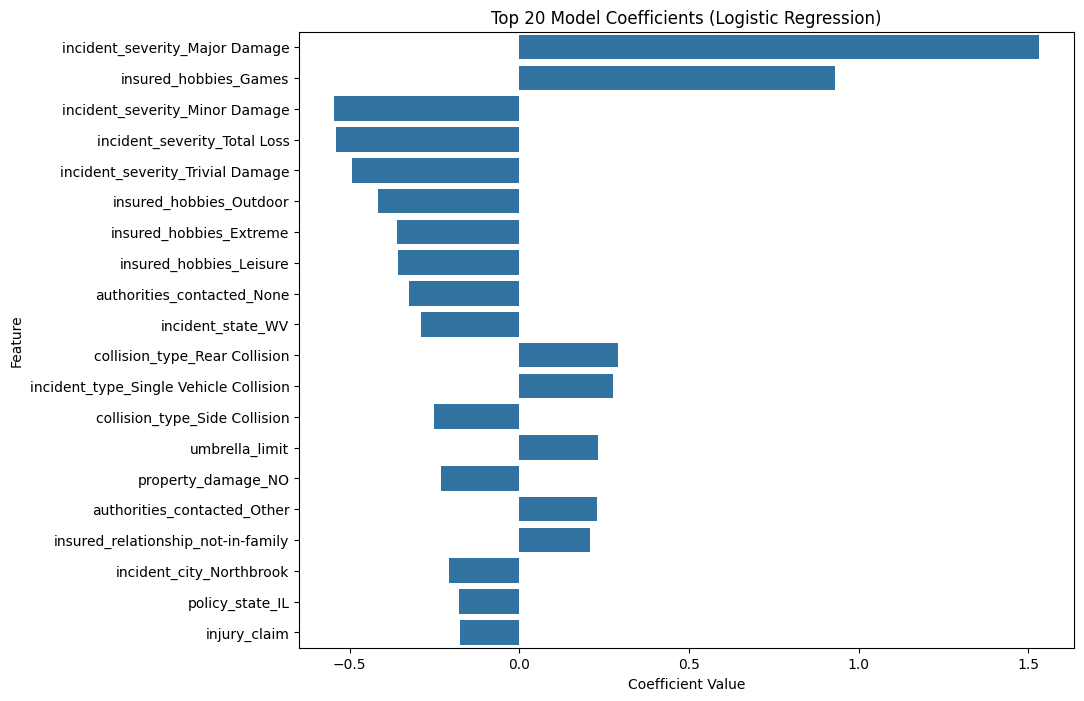

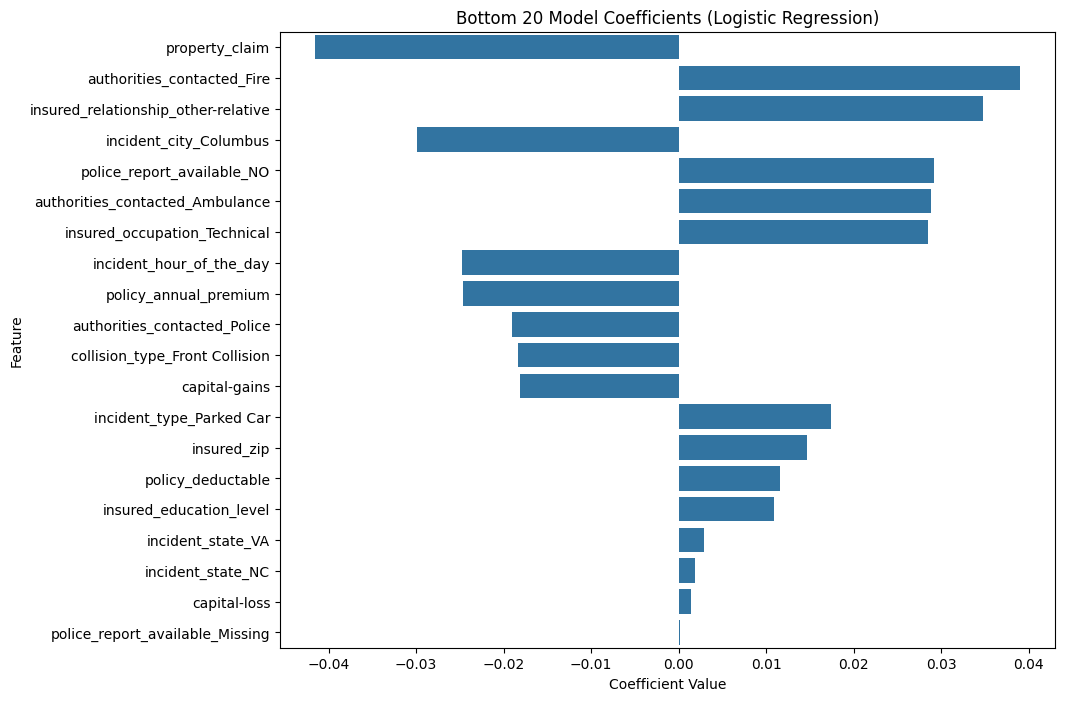

In [ ]:
# visualise the top N coefficients
n_top_coefficients = 20

plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients_df.head(n_top_coefficients))
plt.title(f'Top {n_top_coefficients} Model Coefficients (Logistic Regression)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

# visualise the bottom N coefficients (most negative)
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients_df.tail(n_top_coefficients))
plt.title(f'Bottom {n_top_coefficients} Model Coefficients (Logistic Regression)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

Impact of Coefficient Magnitude: The absolute magnitude of the coefficients directly reflects the strength of a feature's influence. Features with larger absolute values (both positive and negative) are considered more important by the model in determining the probability of fraud.

Most Influential Positive Predictors of Fraud: Features with large positive coefficients are the strongest indicators that the model predicts a higher probability of fraud. The analysis showed that incident severity, specifically 'Major Damage', and certain insured hobbies ('Games') have the most significant positive impact on the likelihood of a claim being fraudulent. This suggests that claims involving major damage and policyholders who engage in 'Games' as a hobby are strongly associated with an increased probability of fraud according to this model.

Most Influential Negative Predictors of Fraud: Features with large negative coefficients are the strongest indicators that the model predicts a lower probability of fraud. The analysis highlighted that incident severity levels lower than 'Major Damage', such as 'Minor Damage', 'Total Loss', and 'Trivial Damage', have a notable negative impact on the likelihood of fraud. This aligns with the expectation that less severe incidents are less likely to be fraudulent.

